# Course project

## Import libs

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
import lightgbm 

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('/Users/Елена/Documents/webinar_2/retail_train.csv')
item_features = pd.read_csv('/Users/Елена/Documents/webinar_2/product.csv')
user_features = pd.read_csv('/Users/Елена/Documents/webinar_2/hh_demographic.csv')

In [3]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


## Set global const

In [24]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# N = Neighbors
N_PREDICT = 200 
TOPK_PRECISION = 5

## Process features dataset

In [25]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

## Split dataset for train, eval, test

In [26]:
# была найдена зависимость между метрикой recall@k и VAL_MATCHER_WEEKS. Чем < VAL_MATCHER_WEEKS, тем выше метрика.
# также чем выше количество кандидатов, тем выше метрика


VAL_MATCHER_WEEKS = 4
VAL_RANKER_WEEKS = 3

In [27]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy() 

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [28]:
# сделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [29]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [30]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2165061, 12) Users: 2498 Items: 84697
val_matcher
Shape: (113429, 12) Users: 2004 Items: 23530
train_ranker
Shape: (113429, 12) Users: 2004 Items: 23530
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


## Prefilter items

In [31]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=3000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 84697 to 3001


## Make cold-start to warm-start

In [32]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

# оставляем общих пользователей
data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (769182, 13) Users: 1816 Items: 3001
val_matcher
Shape: (109401, 12) Users: 1816 Items: 23129
train_ranker
Shape: (109401, 12) Users: 1816 Items: 23129
val_ranker
Shape: (113465, 12) Users: 1816 Items: 23779


## Init/train recommender

In [33]:
recommender = MainRecommender(data_train_matcher)

## Item embeddings for the second model

In [41]:
item_embeddings = recommender.model.item_factors
item_embeddings_mean = item_embeddings.mean(axis=1)

In [68]:
item_ids = [recommender.id_to_itemid[i] for i in range(len(recommender.id_to_itemid))]

In [74]:
df_item_embeddings = pd.DataFrame({'embedddings':item_embeddings_mean, ITEM_COL:item_ids})

In [75]:
df_item_embeddings.head()

,embedddings,item_id
0,0.004154,818981
1,0.004532,819255
2,0.004995,819308
3,0.003269,819400
4,0.005123,819845


## User embeddings for the second model

In [95]:
user_embeddings = recommender.model.user_factors
user_embeddings_mean = user_embeddings.mean(axis=1)

In [96]:
user_embeddings_mean.shape

(1816,)

In [97]:
user_ids = [recommender.id_to_userid[i] for i in range(len(recommender.id_to_userid))]

In [98]:
df_user_embeddings = pd.DataFrame({'embeddings':user_embeddings_mean, USER_COL:user_ids})

In [99]:
df_user_embeddings.head()

,embeddings,user_id
0,2.437476,1
1,3.208150,6
2,2.888338,7
3,4.033916,8
4,1.612202,9


## Eval recall of matching

In [278]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[907466, 909497, 940947, 963542, 1067052, 1559..."
1,6,"[862866, 900802, 938700, 1018553, 1024306, 131..."


In [18]:
def evalRecall(df_result, target_col_name, recommend_model, col_for_result, N=N_PREDICT):
    result_col_name = col_for_result+'_{}'.format(N)
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N)) 
    
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N), axis=1).mean()

In [16]:
def calc_recall(df_result, k=N_PREDICT):
    for col_name in df_result.columns[2:]:
        yield col_name, df_result.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=k), axis=1).mean()

In [93]:
def calc_precision(df_result, top_k):
    for col_name in df_result.columns[2:]:
        yield col_name, df_result.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [282]:
evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations, 'own')

0.13846252429414016

In [283]:
evalRecall(result_eval_matcher, USER_COL, recommender.get_als_recommendations, 'als')

0.0865599632264866

In [284]:
evalRecall(result_eval_matcher, USER_COL, recommender.get_similar_items_recommendation, 'sim_items') 

0.08375322720865956

## recall@200 and VAL_MATCHER_WEEKS = 6

In [29]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.1325640196447428),
 ('als_200', 0.095266440645617),
 ('sim_items_200', 0.08191877382816536)]

## recall@200 and VAL_MATCHER_WEEKS = 5

In [43]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.1332202545007792),
 ('als_200', 0.09874289472723843),
 ('sim_items_200', 0.08234097649504765)]

## recall@200 and VAL_MATCHER_WEEKS = 7

In [57]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.12998549744887522),
 ('als_200', 0.0950765426476774),
 ('sim_items_200', 0.08212757615141783)]

## recall@200 and VAL_MATCHER_WEEKS = 4

In [73]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.13737916106484563),
 ('als_200', 0.1034172746502084),
 ('sim_items_200', 0.08350764267303916)]

## recall@200 and VAL_MATCHER_WEEKS = 4 and top-4000

In [87]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.1397219053854809),
 ('als_200', 0.10310918883576471),
 ('sim_items_200', 0.08496708121764263)]

## recall@200 and VAL_MATCHER_WEEKS = 4 and top-3000

In [101]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.1402211134246535),
 ('als_200', 0.10506702240899152),
 ('sim_items_200', 0.08750553043833217)]

## recall@200 and VAL_MATCHER_WEEKS = 4 and top-3000 and minus the most popular

In [115]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.1402211134246535),
 ('als_200', 0.10490167151036198),
 ('sim_items_200', 0.08587725111898949)]

## recall@200 and VAL_MATCHER_WEEKS = 4 and top-3000 and minus items not in last 12 month

In [135]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.1402211134246535),
 ('als_200', 0.10364666510169986),
 ('sim_items_200', 0.0871249559034328)]

## recall@200 and VAL_MATCHER_WEEKS = 4 and top-3000 and minus items not in last 12 month and log(quantity+1)

In [156]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.1402211134246535),
 ('als_200', 0.10359926117319733),
 ('sim_items_200', 0.08724856007201588)]

## recall@200 and VAL_MATCHER_WEEKS = 4 and top-3000 and minus items not in last 12 month and sales_value mean in user_item 

In [285]:
sorted(calc_recall(result_eval_matcher, 200), key=lambda x: x[1],reverse=True)

[('own_200', 0.13846252429414016),
 ('als_200', 0.0865599632264866),
 ('sim_items_200', 0.08375322720865956)]

## Eval Precision@5 of matching

In [286]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_200', 0.06387665198237931),
 ('als_200', 0.056828193832599475),
 ('sim_items_200', 0.04504405286343639)]

## Ranking part

## Preparing data for train

In [374]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [375]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [376]:
df_match_candidates.head(2)

,user_id,candidates
0,1719,"[843911, 5569376, 1138682, 1056973, 1101502, 1..."
1,2120,"[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [377]:
# разворачиваем товары
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [378]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [379]:
df_match_candidates.head()

,user_id,item_id
0,1719,843911
0,1719,5569376
0,1719,1138682
0,1719,1056973
0,1719,1101502


## Check warm start

In [380]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (363200, 2) Users: 1816 Items: 2999


## Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [381]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [382]:
df_ranker_train.target.value_counts()

0.0    348626
1.0     18291
Name: target, dtype: int64

In [383]:
df_ranker_train.head(2)

,user_id,item_id,target
0,1719,843911,0.0
1,1719,5569376,0.0


## Preparing fatures for model learning

In [384]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [385]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [386]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [387]:
# все данные до data_val_ranker
df_join_train_matcher.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,brand_x,commodity_desc_x,sub_commodity_desc_x,curr_size_of_product_x,manufacturer_y,department_y,brand_y,commodity_desc_y,sub_commodity_desc_y,curr_size_of_product_y
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,...,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,...,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,...,Private,VEGETABLES - ALL OTHERS,CELERY,,69,PRODUCE,Private,VEGETABLES - ALL OTHERS,CELERY,
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,...,National,TROPICAL FRUIT,BANANAS,40 LB,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,...,Private,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB,69,PRODUCE,Private,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB


In [388]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1719,1138682,0.0,456,GROCERY,National,COFFEE,GROUND COFFEE,27.8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1719,1056973,0.0,69,GROCERY,Private,MEAT - SHELF STABLE,CHUNK MEATS - ALL,10 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1719,1101502,0.0,1424,GROCERY,National,BEANS - CANNED GLASS & MW,VARIETY BEANS - KIDNEY PINTO,48 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [725]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [248]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

## Learning of ranking model 

In [162]:
lgb = lightgbm.LGBMClassifier(objective='binary',
                     max_depth=10,
                     n_estimators=500,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)



C:\Programs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Programs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Programs\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(boosting_type='gbdt',
               categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc'],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.05, max_depth=10, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [163]:
train_preds = lgb.predict_proba(X_train)

In [164]:
df_ranker_predict = df_ranker_train.copy()

In [165]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

## Evaluation on test dataset

In [166]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


## Eval matching on test dataset

In [167]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 9.05 s


In [315]:
# померим precision только модели матчинга, чтобы понимать влияение ранжирования на метрики
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.061674008810573146)]

## Eval re-ranked matched result on test dataset

In [90]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [168]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [257]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.14746696035242157)
('own_rec', 0.061674008810573146)


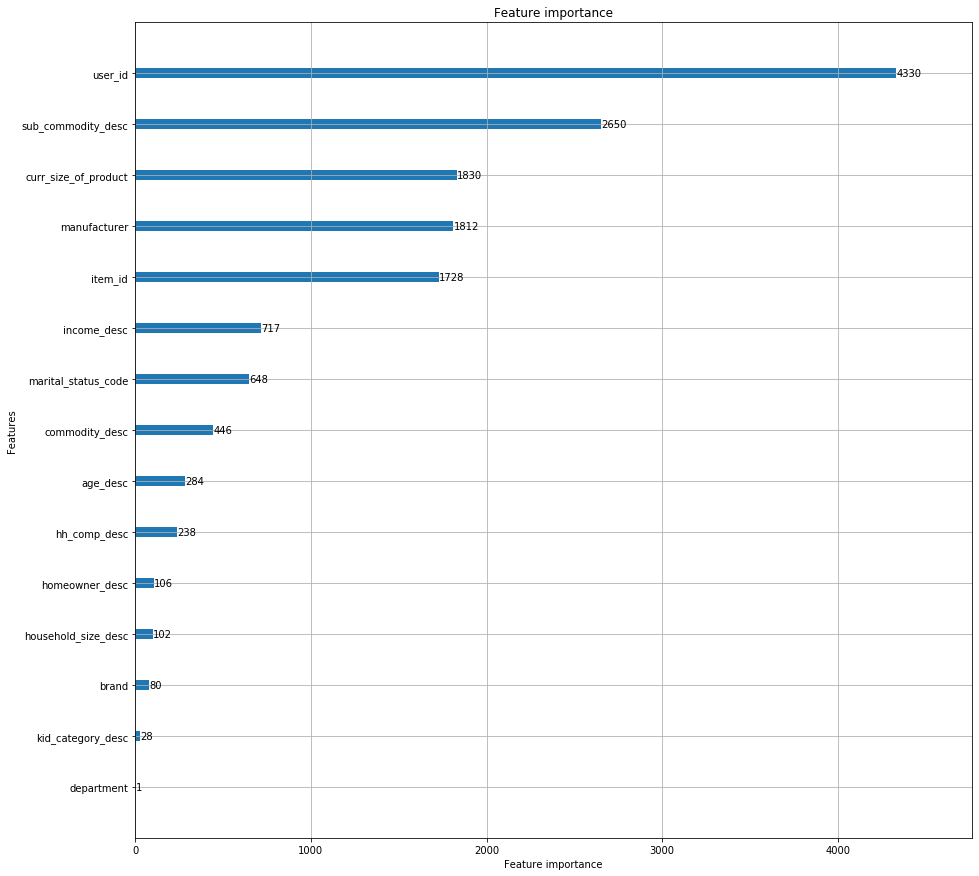

In [258]:
lightgbm.plot_importance(lgb, figsize=(15, 15), importance_type='split')

## Feature engineering

In [389]:
#добавим новую фичу "средняя стоимость купленных товаров"

average_item_price = (df_join_train_matcher.groupby(USER_COL)['sales_value'].sum() / df_join_train_matcher.groupby(USER_COL)['quantity'].sum()). \
    reset_index(name = 'average_item_price')

average_item_price.head()

,user_id,average_item_price
0,1,2.147224
1,2,2.389843
2,3,0.301579
3,4,3.141649
4,5,3.095413


In [390]:
df_ranker_train = df_ranker_train.merge(average_item_price, on=USER_COL, how='left')

In [308]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [309]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [350]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15110132158590148)
('own_rec', 0.061674008810573146)


In [ ]:
#новая фича "средняя стоимость купленных товаров" улучшила качество

In [689]:
#добавим новую фичу "средний чек"
average_check = (df_join_train_matcher.groupby(USER_COL)['sales_value'].sum() / df_join_train_matcher.groupby(USER_COL)['basket_id'].nunique()). \
    reset_index(name = 'average_check')

In [690]:
average_check.head()

,user_id,average_check
0,1,50.130533
1,2,41.442045
2,3,58.067727
3,4,40.003667
4,5,19.712895


In [691]:
df_ranker_train = df_ranker_train.merge(average_check, on=USER_COL, how='left')

In [354]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,average_check
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,38.837925
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,38.837925
2,1719,1138682,0.0,456,GROCERY,National,COFFEE,GROUND COFFEE,27.8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,38.837925
3,1719,1056973,0.0,69,GROCERY,Private,MEAT - SHELF STABLE,CHUNK MEATS - ALL,10 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,38.837925
4,1719,1101502,0.0,1424,GROCERY,National,BEANS - CANNED GLASS & MW,VARIETY BEANS - KIDNEY PINTO,48 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,38.837925


In [363]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [364]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [363]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.14922907488986611)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "средний чек" ухудшила метрику

In [394]:
df_join_train_matcher = df_join_train_matcher.merge(item_features, on=ITEM_COL, how='left')

In [395]:
df_join_train_matcher.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99,586.0,GROCERY,National,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,18 OZ
1,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19,NaN,NaN,NaN,NaN,NaN,NaN
2,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99,NaN,NaN,NaN,NaN,NaN,NaN
3,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50,2209.0,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,LINKS - RAW,12OZ
4,1172,26985025264,1,999999,1,2.29,396,0.00,946,1,0.0,0.0,2.29,NaN,NaN,NaN,NaN,NaN,NaN


In [692]:
# добавим новую фичу "Кол-во покупок в каждой категории"

quantity_per_cat = df_join_train_matcher.groupby([USER_COL,'department'])['quantity'].sum().reset_index(name = 'quantity_per_cat')
df_ranker_train = df_ranker_train.merge(quantity_per_cat, on=[USER_COL, 'department'], how='left')

In [390]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,quantity_per_cat
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,251.0
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,251.0


In [399]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.147687224669602)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "Кол-во покупок в каждой категории" ухудшила метрику

In [349]:
# добавим новую фичу "среднее кол-во покупок в неделю"
user_quantity_per_week = (df_join_train_matcher.groupby(USER_COL)['quantity'].sum() / df_join_train_matcher.week_no.nunique()).reset_index(name = 'user_quantity_per_week')
df_ranker_train = df_ranker_train.merge(user_quantity_per_week, on=USER_COL, how='left')

In [350]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [351]:
X_train.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,user_quantity_per_week
0,1719,843911,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,10.978022
1,1719,5569376,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,10.978022
2,1719,1138682,456,GROCERY,National,COFFEE,GROUND COFFEE,27.8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,10.978022
3,1719,1056973,69,GROCERY,Private,MEAT - SHELF STABLE,CHUNK MEATS - ALL,10 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,10.978022
4,1719,1101502,1424,GROCERY,National,BEANS - CANNED GLASS & MW,VARIETY BEANS - KIDNEY PINTO,48 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,10.978022


In [352]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [359]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.14955947136563716)
('own_rec', 0.061674008810573146)


In [360]:
df_ranker_train.drop('user_quantity_per_week', axis=1, inplace=True)

In [ ]:
# новая фича "среднее кол-во покупок в неделю" ухудшила метрику

In [506]:
df_join_train_matcher = df_join_train_matcher.merge(item_features, on=ITEM_COL, how='left')

In [396]:
# новая фича "общая сумма покупок товара"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left',on=ITEM_COL)

In [397]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,238.13
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,378.66
2,1719,1138682,0.0,456,GROCERY,National,COFFEE,GROUND COFFEE,27.8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,526.57
3,1719,1056973,0.0,69,GROCERY,Private,MEAT - SHELF STABLE,CHUNK MEATS - ALL,10 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,300.51
4,1719,1101502,0.0,1424,GROCERY,National,BEANS - CANNED GLASS & MW,VARIETY BEANS - KIDNEY PINTO,48 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,308.61


In [371]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1515418502202627)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "общая сумма покупок товара" улучшила метрику

In [694]:
# добавим фичу "общее кол-во купленных товаров"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left',on=ITEM_COL)

In [571]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,total_quantity_value
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,116
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,102


In [580]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1513215859030821)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "общее кол-во купленных товаров" ухудшила метрику

In [581]:
df_ranker_train.drop('total_quantity_value', axis=1, inplace=True)

In [582]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02


In [695]:
# добавим метрику "сколько юзеров покупают один и тот же товар"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq'), how='left',on=ITEM_COL)

In [592]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1487885462555051)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "сколько юзеров покупают один и тот же товар" ухудшила метрику

In [594]:
df_ranker_train.drop('item_freq', axis=1, inplace=True)

In [696]:
# новая фича "сколько раз юзер взаимодействовал с товарами"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq'), how='left',on=USER_COL)

In [604]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15022026431717908)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "сколько раз юзер взаимодействовал с товарами" ухудшила метрику

In [605]:
df_ranker_train.drop('user_freq', axis=1, inplace=True)

In [697]:
# добавим новую фичу "общая сумма покупок юзера"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sales_value').sum().rename('total_user_sales_value'), how='left',on=USER_COL)

In [607]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,total_user_sales_value
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,2058.41
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,2058.41


In [616]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.14867841409691485)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "общая сумма покупок юзера" ухудшила метрику

In [617]:
df_ranker_train.drop('total_user_sales_value', axis=1, inplace=True)

In [698]:
# добавим новую фичу "среднее количество товаров в неделю"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=ITEM_COL)

In [619]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,item_quantity_per_week
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,1.274725
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,1.120879


In [629]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1513215859030821)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "среднее количество товаров в неделю" ухудшила метрику

In [630]:
df_ranker_train.drop('item_quantity_per_week', axis=1, inplace=True)

In [699]:
# новая фича "количество товаров на корзину"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

In [642]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,item_quantity_per_basket
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,0.000473
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,0.000416


In [651]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1513215859030821)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "количество товаров на корзину" ухудшила метрику

In [652]:
df_ranker_train.drop('item_quantity_per_basket', axis=1, inplace=True)

In [700]:
# новая фича "количество товаров юзера на корзину"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_baskter')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)

In [654]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,user_quantity_per_baskter
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,0.004074
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,0.004074


In [663]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15121145374449163)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "количество товаров юзера на корзину" ухудшила метрику

In [664]:
df_ranker_train.drop('user_quantity_per_baskter', axis=1, inplace=True)

In [701]:
# новая фича "частота товара на корзину"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

In [675]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1487885462555051)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "частота товара на корзину" ухудшила метрику

In [676]:
df_ranker_train.drop('item_freq_per_basket', axis=1, inplace=True)

In [702]:
# новая фича "частота юзера на корзину" 
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)

In [686]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15022026431717908)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "частота юзера на корзину" ухудшила метрику

In [687]:
df_ranker_train.drop('user_freq_per_basket', axis=1, inplace=True)

In [ ]:
# добавим фичу Средняя сумма покупки 1 товара в каждой категории 

In [ ]:
Item_cat_average_price = (df_join_train_matcher.groupby('department')['sales_value'].sum() / df_join_train_matcher.groupby('department')['quantity'].sum()).reset_index(name = 'Item_cat_average_price')

In [740]:
df_ranker_train = df_ranker_train.merge(Item_cat_average_price, on='department', how='left')

In [741]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,Item_cat_average_price
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,1.857041
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,1.857041


In [151]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [152]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [756]:
[X_train.columns[-1]]

['Item_cat_average_price']

In [746]:
X_train.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,Item_cat_average_price
0,1719,843911,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,1.857041
1,1719,5569376,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,1.857041


In [764]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1515418502202627)
('own_rec', 0.061674008810573146)


In [ ]:
# метрика не изменилась

In [788]:
#добавим новую фичу
#(Кол-во покупок юзером конкретной категории в неделю) - 
#(Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
user_quantity_per_week = (df_join_train_matcher.groupby(['user_id', 'department'])['quantity'].count() / df_join_train_matcher.week_no.nunique()).reset_index(name='user_quantity_per_week')
average_quantity_per_week = (df_join_train_matcher.groupby(['department'])['quantity'].count() / df_join_train_matcher.week_no.nunique()).reset_index(name='average_quantity_per_week')


In [789]:
df_ranker_train = df_ranker_train.merge(average_quantity_per_week, on='department', how='left')

In [790]:
df_ranker_train = df_ranker_train.merge(user_quantity_per_week, on=['department', USER_COL], how='left')

In [792]:
df_ranker_train['ave_item_count_user_cat_week'] = df_ranker_train['user_quantity_per_week'] - df_ranker_train['average_quantity_per_week']

In [795]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,Item_cat_average_price,ave_item_count_user_cat_week
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,1.857041,-15851.252747
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,1.857041,-15851.252747
2,1719,1138682,0.0,456,GROCERY,National,COFFEE,GROUND COFFEE,27.8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,562.52,1.857041,-15851.252747
3,1719,1056973,0.0,69,GROCERY,Private,MEAT - SHELF STABLE,CHUNK MEATS - ALL,10 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,928.76,1.857041,-15851.252747
4,1719,1101502,0.0,1424,GROCERY,National,BEANS - CANNED GLASS & MW,VARIETY BEANS - KIDNEY PINTO,48 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,341.20,1.857041,-15851.252747


In [794]:
df_ranker_train.drop(['average_quantity_per_week', 'user_quantity_per_week'], axis=1, inplace=True)

In [82]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [959]:
cat_feats = X_train.columns[2:15].tolist()
cat_feats.extend(['Item_cat_average_price'])
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'Item_cat_average_price']

In [810]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.14680616740087934)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "(Кол-во покупок юзером конкретной категории в неделю) - 
# (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)" ухудшила метрику

In [811]:
df_ranker_train.drop('ave_item_count_user_cat_week', axis=1, inplace=True)

In [812]:
# добавим новую фичу "количество походов в магазин в неделю"
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('basket_id').nunique().rename('quantyty_of_purchases_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=USER_COL)

In [814]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price_x,total_item_sales_value,Item_cat_average_price,quantyty_of_purchases_per_week
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,1.857041,0.582418
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,1.857041,0.582418
2,1719,1138682,0.0,456,GROCERY,National,COFFEE,GROUND COFFEE,27.8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,562.52,1.857041,0.582418
3,1719,1056973,0.0,69,GROCERY,Private,MEAT - SHELF STABLE,CHUNK MEATS - ALL,10 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,928.76,1.857041,0.582418
4,1719,1101502,0.0,1424,GROCERY,National,BEANS - CANNED GLASS & MW,VARIETY BEANS - KIDNEY PINTO,48 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,341.20,1.857041,0.582418


In [823]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15099118942731107)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "количество походов в магазин в неделю" ухудшила метрику

In [824]:
df_ranker_train.drop('quantyty_of_purchases_per_week', axis=1, inplace=True)

In [ ]:
# новая фича mean  кол-ва уникальных товаров в корзине клиента

In [843]:
unique_items = df_join_train_matcher.groupby([USER_COL,'basket_id'])[ITEM_COL].nunique().reset_index()

In [847]:
unique_items.columns = ['user_id', 'basket_id', 'nunique_items']

In [848]:
unique_items.head()

,user_id,basket_id,nunique_items
0,1,27601281299,30
1,1,27774192959,12
2,1,28024266849,12
3,1,28106322445,23
4,1,28235481967,17


In [854]:
unique_items_per_user = unique_items.groupby(USER_COL)['nunique_items'].apply(list).reset_index()
unique_items_per_user.columns = ['user_id', 'nunique_items_in_basket']

In [855]:
unique_items_per_user.head()

,user_id,nunique_items_in_basket
0,1,"[30, 12, 12, 23, 17, 10, 9, 39, 36, 29, 18, 37..."
1,2,"[9, 2, 4, 19, 10, 13, 11, 6, 12, 8, 8, 57, 5, ..."
2,3,"[17, 7, 30, 1, 40, 3, 4, 19, 13, 35, 40, 25, 5..."
3,4,"[38, 29, 8, 6, 5, 35, 22, 11, 10, 9, 7, 10, 8,..."
4,5,"[2, 1, 3, 13, 20, 1, 1, 5, 11, 10, 15, 8, 9, 1..."


In [856]:
unique_items_per_user['mean_nunique_items_in_basket'] = unique_items_per_user['nunique_items_in_basket'].apply(lambda x: np.mean(x))

In [857]:
unique_items_per_user.head()

,user_id,nunique_items_in_basket,mean_nunique_items_in_basket
0,1,"[30, 12, 12, 23, 17, 10, 9, 39, 36, 29, 18, 37...",20.093333
1,2,"[9, 2, 4, 19, 10, 13, 11, 6, 12, 8, 8, 57, 5, ...",14.886364
2,3,"[17, 7, 30, 1, 40, 3, 4, 19, 13, 35, 40, 25, 5...",19.772727
3,4,"[38, 29, 8, 6, 5, 35, 22, 11, 10, 9, 7, 10, 8,...",10.033333
4,5,"[2, 1, 3, 13, 20, 1, 1, 5, 11, 10, 15, 8, 9, 1...",5.763158


In [858]:
df_ranker_train = df_ranker_train.merge(unique_items_per_user[[USER_COL, 'mean_nunique_items_in_basket']], on=USER_COL, how='left')

In [859]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price_x,total_item_sales_value,Item_cat_average_price,mean_nunique_items_in_basket
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,1.857041,15.396226
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,1.857041,15.396226
2,1719,1138682,0.0,456,GROCERY,National,COFFEE,GROUND COFFEE,27.8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,562.52,1.857041,15.396226
3,1719,1056973,0.0,69,GROCERY,Private,MEAT - SHELF STABLE,CHUNK MEATS - ALL,10 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,928.76,1.857041,15.396226
4,1719,1101502,0.0,1424,GROCERY,National,BEANS - CANNED GLASS & MW,VARIETY BEANS - KIDNEY PINTO,48 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,341.20,1.857041,15.396226


In [868]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1506607929515401)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича mean  кол-ва уникальных товаров в корзине клиента ухудшила метрику

In [869]:
df_ranker_train.drop('mean_nunique_items_in_basket', axis=1, inplace=True)

In [ ]:
# новая фича max  кол-ва уникальных товаров в корзине клиента

In [870]:
unique_items_per_user['max_nunique_items_in_basket'] = unique_items_per_user['nunique_items_in_basket'].apply(lambda x: np.max(x))

In [871]:
unique_items_per_user.head(2)

,user_id,nunique_items_in_basket,mean_nunique_items_in_basket,max_nunique_items_in_basket
0,1,"[30, 12, 12, 23, 17, 10, 9, 39, 36, 29, 18, 37...",20.093333,55
1,2,"[9, 2, 4, 19, 10, 13, 11, 6, 12, 8, 8, 57, 5, ...",14.886364,57


In [872]:
df_ranker_train = df_ranker_train.merge(unique_items_per_user[[USER_COL, 'max_nunique_items_in_basket']], on=USER_COL, how='left')

In [881]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15088105726872075)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича max  кол-ва уникальных товаров в корзине клиента ухудшила метрику

In [883]:
df_ranker_train.drop('max_nunique_items_in_basket', axis=1, inplace=True)

In [ ]:
# новая фича min кол-ва уникальных товаров в корзине клиента

In [884]:
unique_items_per_user['min_nunique_items_in_basket'] = unique_items_per_user['nunique_items_in_basket'].apply(lambda x: np.min(x))

In [885]:
df_ranker_train = df_ranker_train.merge(unique_items_per_user[[USER_COL, 'min_nunique_items_in_basket']], on=USER_COL, how='left')

In [886]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price_x,total_item_sales_value,Item_cat_average_price,min_nunique_items_in_basket
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,1.857041,1
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,1.857041,1


In [895]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.14922907488986623)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича min кол-ва уникальных товаров в корзине клиента ухудшила метрику

In [896]:
df_ranker_train.drop('min_nunique_items_in_basket', axis=1, inplace=True)

In [ ]:
# новая фича std  кол-ва уникальных товаров в корзине клиента

In [897]:
unique_items_per_user['std_nunique_items_in_basket'] = unique_items_per_user['nunique_items_in_basket'].apply(lambda x: np.std(x))

In [898]:
df_ranker_train = df_ranker_train.merge(unique_items_per_user[[USER_COL, 'std_nunique_items_in_basket']], on=USER_COL, how='left')

In [899]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price_x,total_item_sales_value,Item_cat_average_price,std_nunique_items_in_basket
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,292.08,1.857041,19.18956
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,397.02,1.857041,19.18956


In [908]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15066079295154033)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича std кол-ва уникальных товаров в корзине клиента ухудшила метрику

In [909]:
df_ranker_train.drop('std_nunique_items_in_basket', axis=1, inplace=True)

In [ ]:
# новая фича mean кол-ва уникальных категорий в корзине клиента

In [398]:
unique_cats = df_join_train_matcher.groupby([USER_COL,'basket_id'])['department'].nunique().reset_index()
unique_cats.head()

,user_id,basket_id,department
0,1,27601281299,3
1,1,27774192959,1
2,1,28024266849,2
3,1,28106322445,2
4,1,28235481967,2


In [399]:
unique_cats_per_user = unique_cats.groupby(USER_COL)['department'].apply(list).reset_index()
unique_cats_per_user.columns = [USER_COL, 'nunique_cat_per_basket']

In [400]:
unique_cats_per_user.head(2)

,user_id,nunique_cat_per_basket
0,1,"[3, 1, 2, 2, 2, 2, 1, 3, 5, 4, 3, 3, 1, 2, 4, ..."
1,6,"[3, 3, 1, 1, 2, 0, 3, 2, 4, 0, 2, 3, 1, 3, 0, ..."


In [401]:
unique_cats_per_user['mean_nunique_cat_per_basket'] = unique_cats_per_user['nunique_cat_per_basket'].apply(lambda x: np.mean(x))

In [402]:
unique_cats_per_user.head(2)

,user_id,nunique_cat_per_basket,mean_nunique_cat_per_basket
0,1,"[3, 1, 2, 2, 2, 2, 1, 3, 5, 4, 3, 3, 1, 2, 4, ...",2.303030
1,6,"[3, 3, 1, 1, 2, 0, 3, 2, 4, 0, 2, 3, 1, 3, 0, ...",1.593137


In [403]:
df_ranker_train = df_ranker_train.merge(unique_cats_per_user[[USER_COL, 'mean_nunique_cat_per_basket']], on=USER_COL, how='left')

In [404]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,mean_nunique_cat_per_basket
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,238.13,1.76
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,378.66,1.76


In [928]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15253303964757553)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича mean кол-ва уникальных категорий в корзине клиента улучшила метрику

In [ ]:
# новая фича max кол-ва уникальных категорий в корзине клиента

In [929]:
unique_cats_per_user['max_nunique_cat_per_basket'] = unique_cats_per_user['nunique_cat_per_basket'].apply(lambda x: np.max(x))

In [930]:
df_ranker_train = df_ranker_train.merge(unique_cats_per_user[[USER_COL, 'max_nunique_cat_per_basket']], on=USER_COL, how='left')

In [937]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15253303964757553)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича max кол-ва уникальных категорий в корзине клиента не ухудшила метрику

In [945]:
df_ranker_train.drop('max_nunique_cat_per_basket', axis=1, inplace=True)

In [ ]:
# новая фича min кол-ва уникальных категорий в корзине клиента

In [405]:
unique_cats_per_user['min_nunique_cat_per_basket'] = unique_cats_per_user['nunique_cat_per_basket'].apply(lambda x: np.min(x))

In [406]:
unique_cats_per_user.head(2)

,user_id,nunique_cat_per_basket,mean_nunique_cat_per_basket,min_nunique_cat_per_basket
0,1,"[3, 1, 2, 2, 2, 2, 1, 3, 5, 4, 3, 3, 1, 2, 4, ...",2.303030,0
1,6,"[3, 3, 1, 1, 2, 0, 3, 2, 4, 0, 2, 3, 1, 3, 0, ...",1.593137,0


In [407]:
df_ranker_train = df_ranker_train.merge(unique_cats_per_user[[USER_COL, 'min_nunique_cat_per_basket']], on=USER_COL, how='left')

In [408]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,mean_nunique_cat_per_basket,min_nunique_cat_per_basket
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,238.13,1.76,0
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.06047,378.66,1.76,0


In [418]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15319383259911729)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича min кол-ва уникальных категорий в корзине клиента улучшила метрику

In [ ]:
# новая фича std кол-ва уникальных категорий в корзине клиента

In [955]:
unique_cats_per_user['std_nunique_cat_per_basket'] = unique_cats_per_user['nunique_cat_per_basket'].apply(lambda x: np.std(x))

In [956]:
unique_cats_per_user.head(2)

,user_id,nunique_cat_per_basket,mean_nunique_cat_per_basket,max_nunique_cat_per_basket,min_nunique_cat_per_basket,std_nunique_cat_per_basket
0,1,"[6, 3, 4, 4, 5, 5, 4, 6, 7, 6, 5, 6, 2, 4, 7, ...",3.986667,8,1,1.969726
1,2,"[3, 1, 2, 5, 3, 3, 7, 2, 3, 1, 2, 6, 2, 1, 3, ...",3.227273,7,1,1.649568


In [957]:
df_ranker_train = df_ranker_train.merge(unique_cats_per_user[[USER_COL, 'std_nunique_cat_per_basket']], on=USER_COL, how='left')

In [966]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.14856828193832444)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича std кол-ва уникальных категорий в корзине клиента ухудшила метрику

In [967]:
df_ranker_train.drop(['std_nunique_cat_per_basket', 'Item_cat_average_price'], axis=1, inplace=True)

In [976]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15275330396475598)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "средняя скидка"

In [419]:
ave_disc = (df_join_train_matcher.groupby(USER_COL)['retail_disc'].sum() / df_join_train_matcher.groupby(USER_COL)['retail_disc'].count()).reset_index(name='average_disc')
ave_disc.head()

,user_id,average_disc
0,1,-0.439450
1,6,-0.580220
2,7,-0.395695
3,8,-0.691358
4,9,-0.510252


In [420]:
df_ranker_train = df_ranker_train.merge(ave_disc, on=USER_COL, how='left')

In [987]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1526431718061658)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "средняя скидка" ухудшила метрику

In [421]:
df_ranker_train.drop('average_disc', axis=1, inplace=True)

In [ ]:
# новая фича "доля купленных товаров со скидками"

In [422]:
disc_ratio = (df_join_train_matcher[df_join_train_matcher.retail_disc != 0].groupby(USER_COL)['quantity'].sum() / df_join_train_matcher.groupby(USER_COL)['quantity'].sum()).reset_index(name='disc_ratio') 
disc_ratio.head()  

,user_id,disc_ratio
0,1,0.441397
1,6,0.334423
2,7,0.413442
3,8,0.472585
4,9,0.530612


In [423]:
df_ranker_train = df_ranker_train.merge(disc_ratio, on=USER_COL, how='left')

In [424]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,mean_nunique_cat_per_basket,min_nunique_cat_per_basket,disc_ratio
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,2.06047,238.13,1.76,0,0.446188
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,2.06047,378.66,1.76,0,0.446188
2,1719,1138682,0.0,456,GROCERY,National,COFFEE,GROUND COFFEE,27.8 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,2.06047,526.57,1.76,0,0.446188
3,1719,1056973,0.0,69,GROCERY,Private,MEAT - SHELF STABLE,CHUNK MEATS - ALL,10 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,2.06047,300.51,1.76,0,0.446188
4,1719,1101502,0.0,1424,GROCERY,National,BEANS - CANNED GLASS & MW,VARIETY BEANS - KIDNEY PINTO,48 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,2.06047,308.61,1.76,0,0.446188


In [175]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15297356828193664)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "доля купленных товаров со скидками" улучшила метрику

In [ ]:
# новая фича "среднее кол-во дней между покупками"

In [93]:
df = df_join_train_matcher.groupby([USER_COL, 'basket_id'])['day'].mean().reset_index(name='day')

In [94]:
df.sort_values([USER_COL, 'day'], inplace=True)

In [95]:
df.head()

,user_id,basket_id,day
0,1,27601281299,51
1,1,27774192959,67
2,1,28024266849,88
3,1,28106322445,94
4,1,28235481967,101


In [88]:
df['previous_day'] = df.groupby(USER_COL)['day'].shift()

In [99]:
df['previous_day'] = df['previous_day'].fillna(df['day'])

In [100]:
df['days_bw_purchases'] = df['day'] - df['previous_day']

In [101]:
mean_days_bw_purchases = df.groupby(USER_COL)['days_bw_purchases'].mean().reset_index(name='mean_days_bw_purchases')

In [102]:
mean_days_bw_purchases.head()

,user_id,mean_days_bw_purchases
0,1,7.746667
1,2,11.795455
2,3,10.522727
3,4,17.433333
4,5,13.263158


In [115]:
df_ranker_train = df_ranker_train.merge(mean_days_bw_purchases, on=USER_COL, how='left')

In [122]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15297356828193664)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "среднее кол-во дней между покупками" не улучшила метрику

In [124]:
df_ranker_train.drop('mean_days_bw_purchases', axis = 1, inplace=True)

In [428]:
df_ranker_train.to_csv('train_dataset_final.csv', index=False)

In [ ]:
# новая фича "item's embeddings"

In [76]:
df_item_embeddings.head()

,embedddings,item_id
0,0.004154,818981
1,0.004532,819255
2,0.004995,819308
3,0.003269,819400
4,0.005123,819845


In [149]:
df_ranker_train = df_ranker_train.merge(df_item_embeddings, on=ITEM_COL, how='left')

In [161]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,hh_comp_desc,household_size_desc,kid_category_desc,average_item_price,total_item_sales_value,mean_nunique_cat_per_basket,min_nunique_cat_per_basket,disc_ratio,embedddings,embeddings
0,1719,843911,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,NaN,...,NaN,NaN,NaN,2.06047,238.13,1.76,0,0.446188,0.003262,3.310144
1,1719,5569376,0.0,1276,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CARB FLVRD DRNKNG/MNRL WAT,101.4 OZ,NaN,...,NaN,NaN,NaN,2.06047,378.66,1.76,0,0.446188,0.003526,3.310144
2,1719,1138682,0.0,456,GROCERY,National,COFFEE,GROUND COFFEE,27.8 OZ,NaN,...,NaN,NaN,NaN,2.06047,526.57,1.76,0,0.446188,0.004521,3.310144
3,1719,1056973,0.0,69,GROCERY,Private,MEAT - SHELF STABLE,CHUNK MEATS - ALL,10 OZ,NaN,...,NaN,NaN,NaN,2.06047,300.51,1.76,0,0.446188,0.003872,3.310144
4,1719,1101502,0.0,1424,GROCERY,National,BEANS - CANNED GLASS & MW,VARIETY BEANS - KIDNEY PINTO,48 OZ,NaN,...,NaN,NaN,NaN,2.06047,308.61,1.76,0,0.446188,0.004194,3.310144


In [94]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1529735682819367)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "item's embeddings" практически никак не повлияла на метрику

In [ ]:
# новая фича "users's embeddings"

In [101]:
df_user_embeddings.head(2)

,embeddings,user_id
0,2.437476,1
1,3.208150,6


In [150]:
df_ranker_train = df_ranker_train.merge(df_user_embeddings, on=USER_COL, how='left')

In [169]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1593612334801744)
('own_rec', 0.061674008810573146)


In [ ]:
# новая фича "users's embeddings" улучшила метрику

In [148]:
df_ranker_train = pd.read_csv('/Users/Елена/Documents/webinar_8/train_dataset_final.csv')

C:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


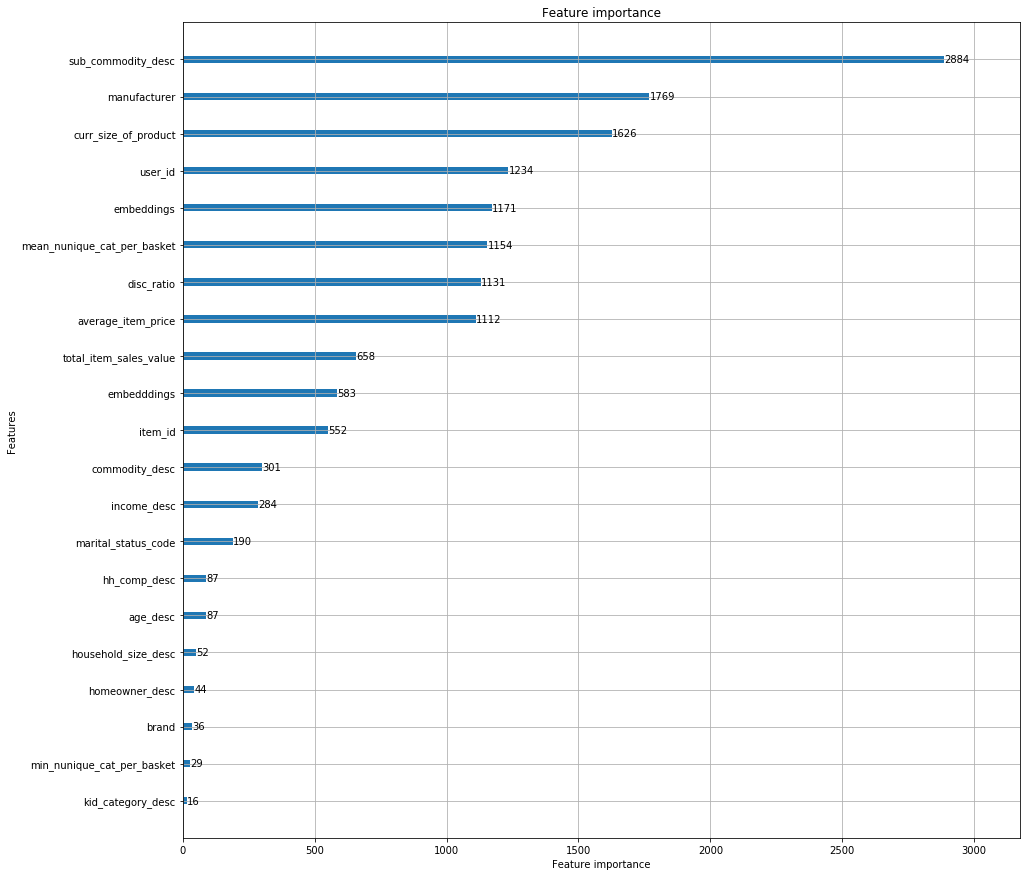

In [170]:
lightgbm.plot_importance(lgb, figsize=(15, 15), importance_type='split')

## Final evaluation

In [141]:
df_test = pd.read_csv('/Users/Елена/Documents/webinar_8/retail_test1.csv')

In [142]:
df_test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0
3,1602,41665647035,664,827939,1,7.99,334,0.0,1741,96,0.0,0.0
4,1602,41665647035,664,927712,1,0.59,334,-0.4,1741,96,0.0,0.0


In [143]:
result_test = df_test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]
result_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


In [171]:
result_test['reranked_own_rec'] = result_test[USER_COL].apply(lambda user_id: rerank(user_id))

In [172]:
print(list(calc_precision(result_test, TOPK_PRECISION)))

C:\Users\Елена\Documents\webinar_8\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


[('reranked_own_rec', 0.13045653533458326)]
